In [5]:
import dpm

In [6]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.ion()

import pandas as pd
import numpy as np
from torch import nn

# https://www.ethanrosenthal.com/2018/12/06/spacecutter-ordinal-regression/

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [12]:
from dpm.models import (
    OrdinalLayer, OrdinalModel,
    OrdinalLoss,
    exp_cdf, erf_cdf, tanh_cdf,
    normal_cdf, laplace_cdf, cauchy_cdf
)
from dpm.visualize import (
    plot_ordinal_classes,
    plot_ordinal_classes_from_layer
)

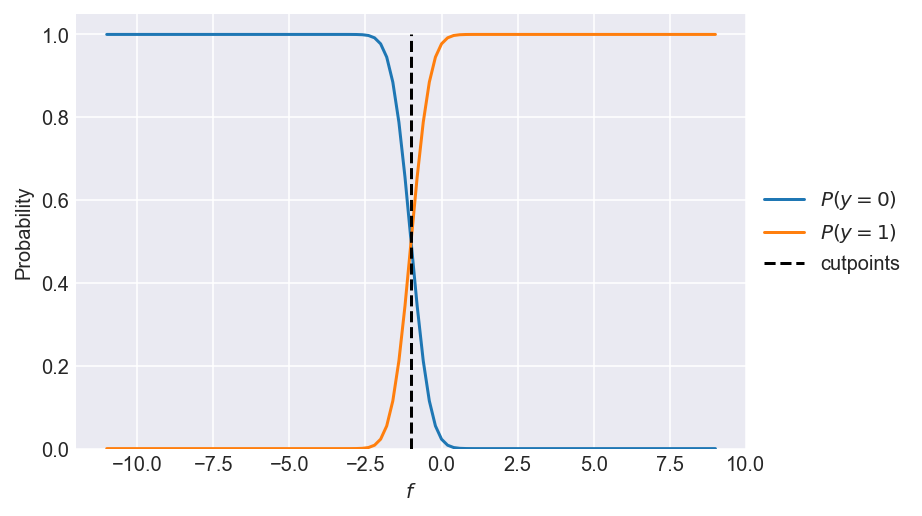

In [13]:
m = OrdinalLayer(2, func=torch.distributions.Normal(0, 0.5).cdf)

num_points = 101
cutpoints = m.threshold.detach()
offset = cutpoints.std() + 2 if len(cutpoints) > 1 else 10
f = torch.linspace(cutpoints.min() - offset, 
                   cutpoints.max() + offset, 
                   num_points)

plot_ordinal_classes(f, 
                     cutpoints, 
                     m.func)

In [14]:
print(m.threshold)

tensor([-1.], grad_fn=<CumsumBackward>)


In [15]:
red = pd.read_csv('winequality-red.csv', sep=';')
white = pd.read_csv('winequality-white.csv', sep=';')

wine = pd.concat((red, white))

wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


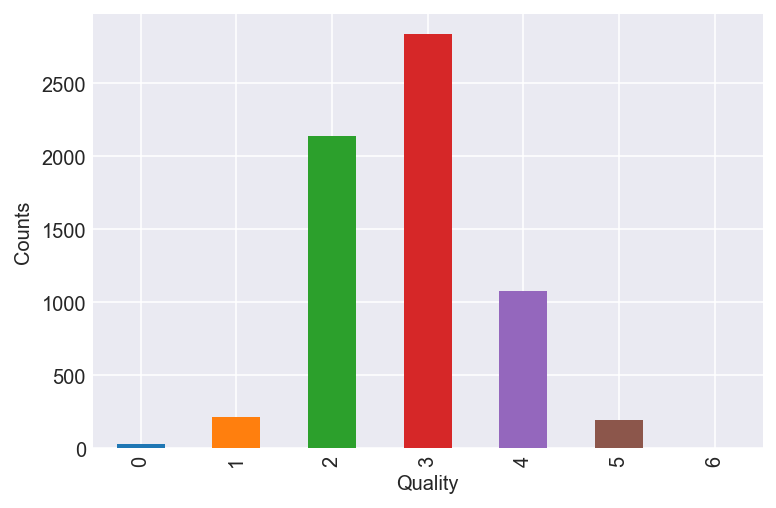

In [16]:
quality = wine.quality - wine.quality.min()
(quality.value_counts()
  .sort_index()
  .plot(kind='bar'));
plt.ylabel('Counts');
plt.xlabel('Quality');

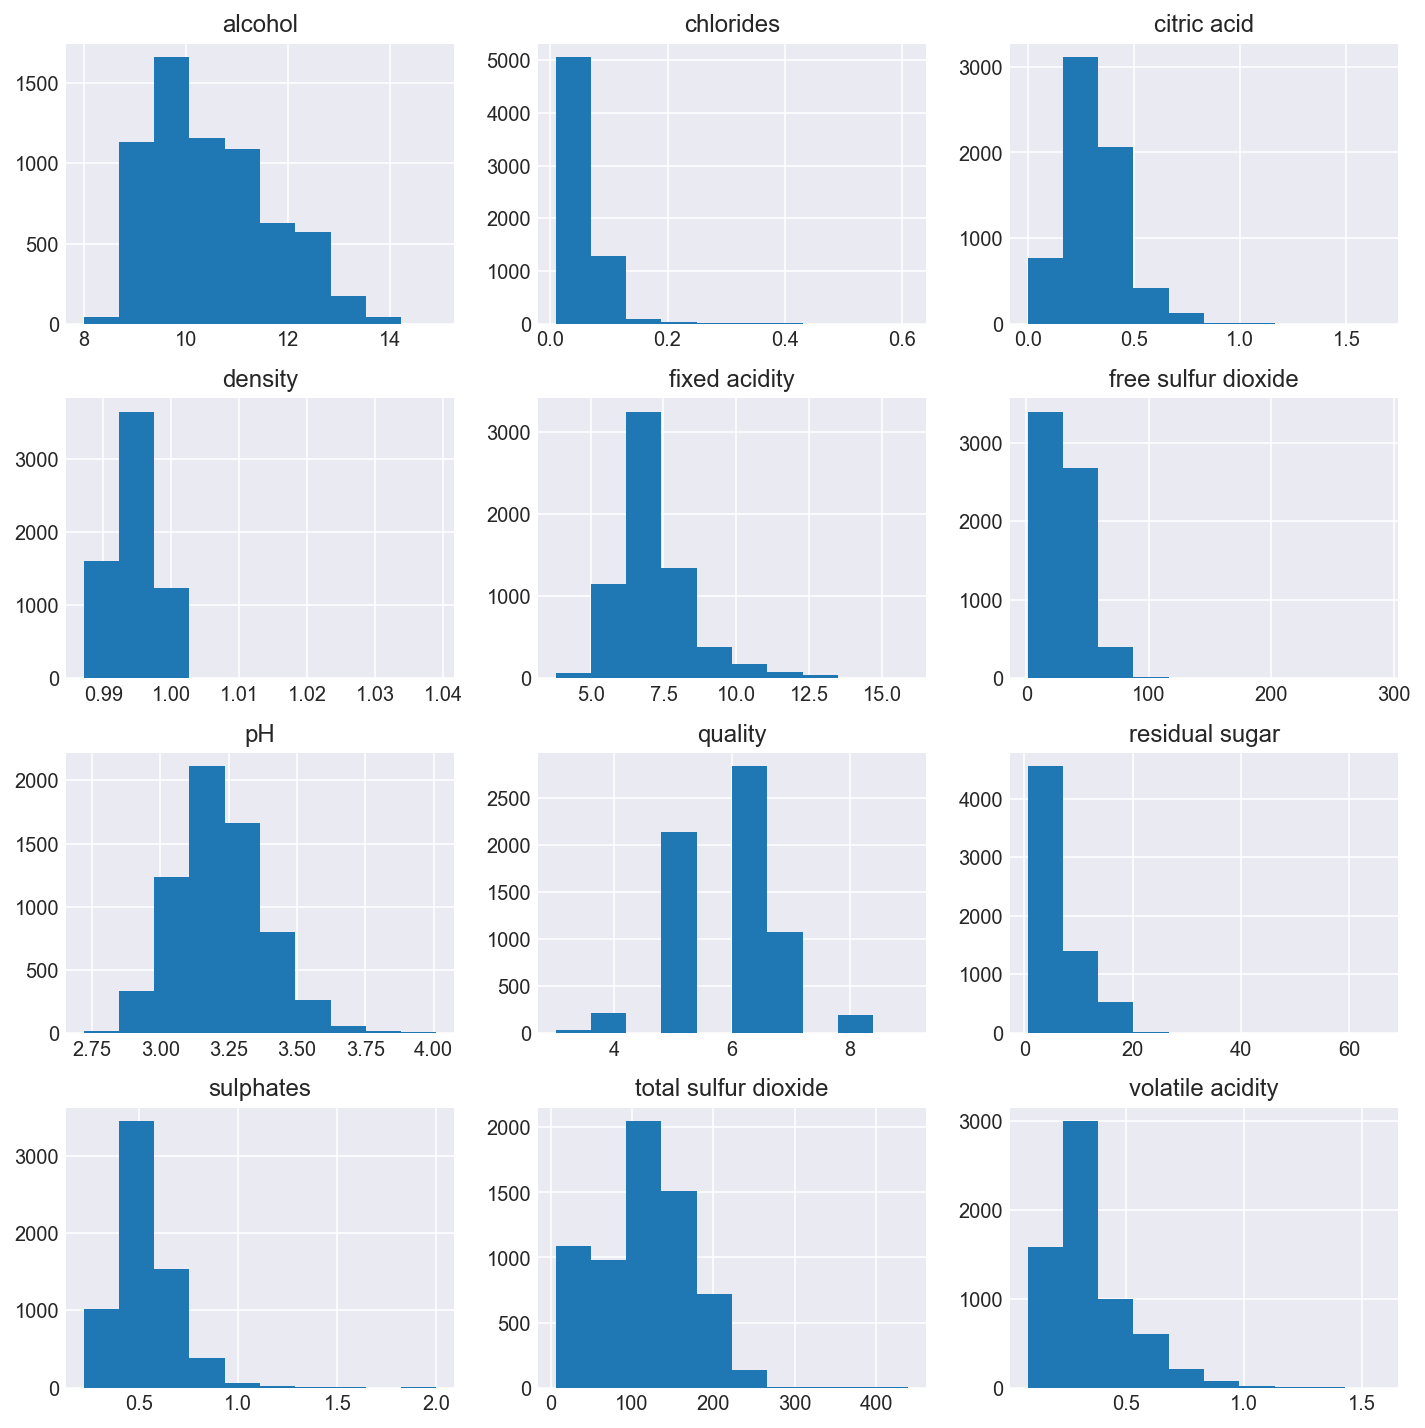

In [17]:
wine.hist(figsize=(10, 10));
plt.tight_layout();

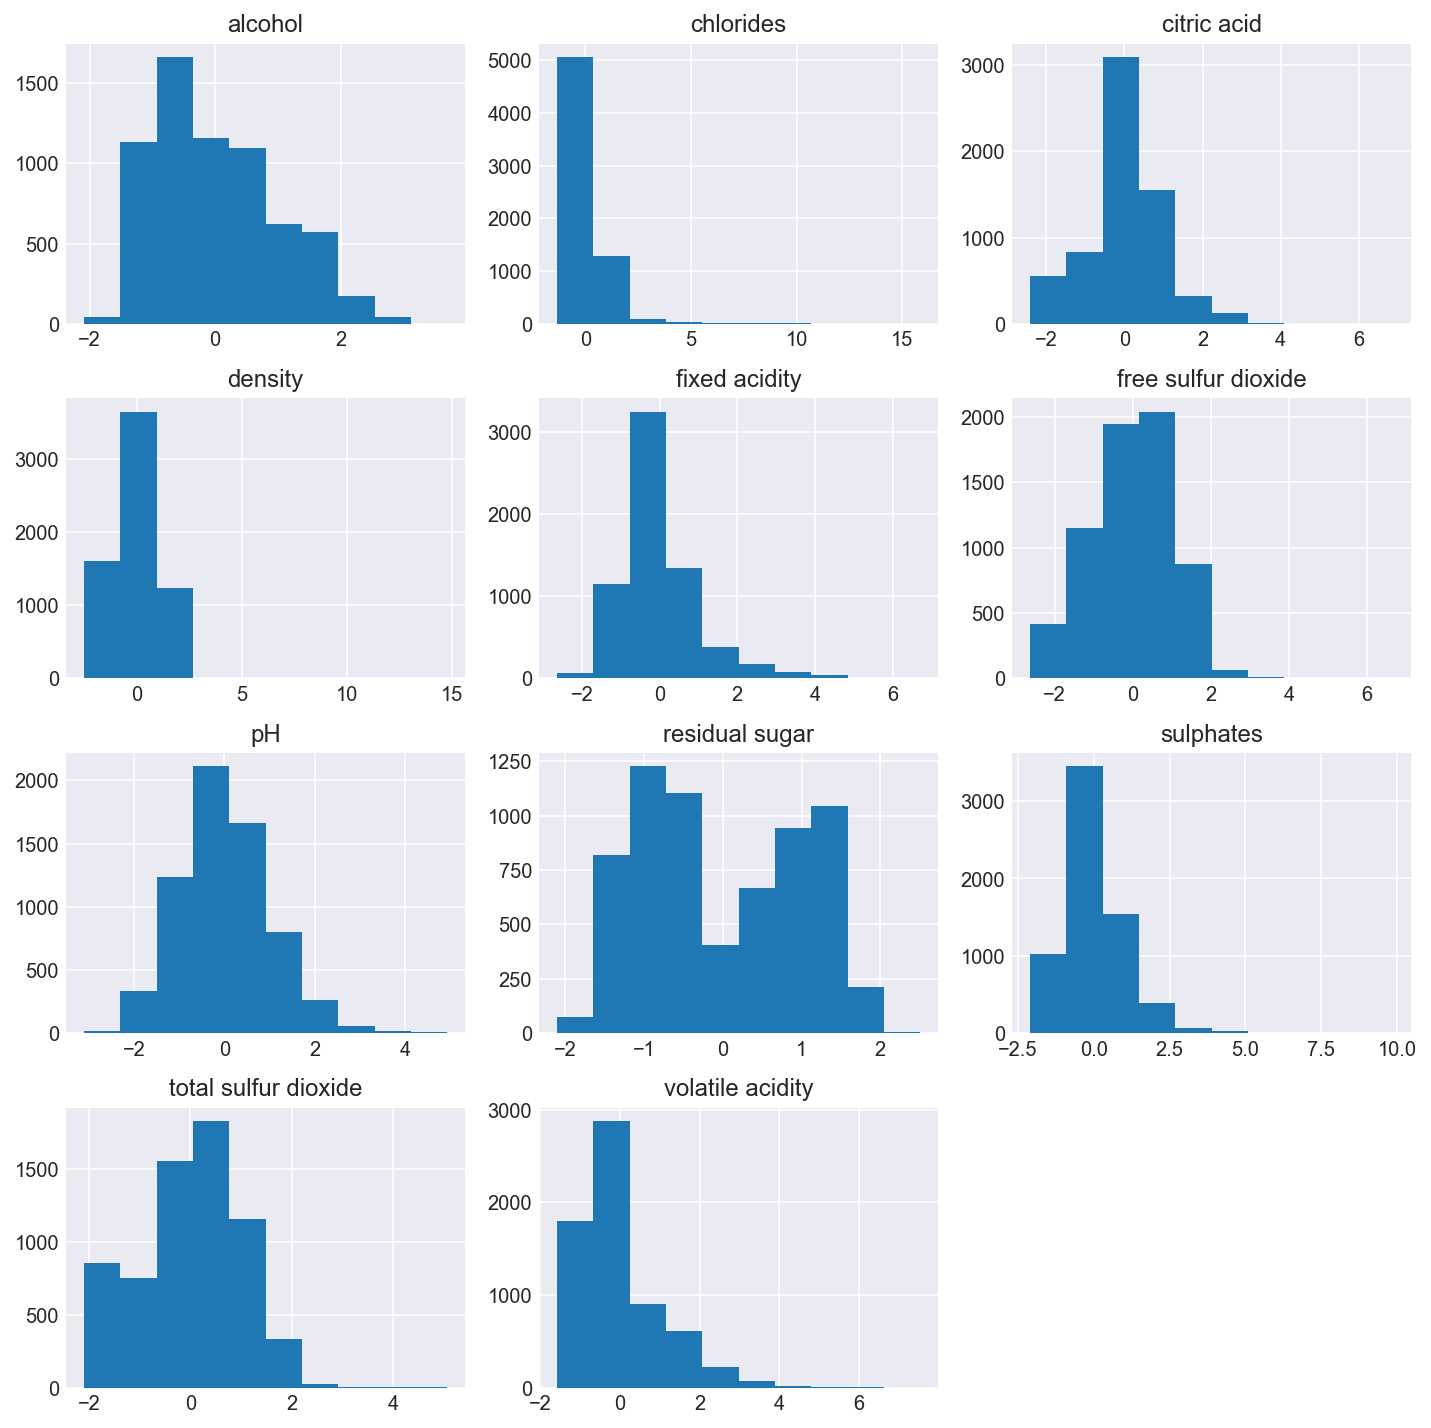

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer

gaussian_columns = ['alcohol', 'chlorides', 'fixed acidity',
                    'density',
                    'pH', 'sulphates', 'volatile acidity']
power_columns = ['citric acid', 'free sulfur dioxide', 'residual sugar',
                 'total sulfur dioxide']
column_transformer = ColumnTransformer([
    ('gaussian', StandardScaler(), gaussian_columns),
    ('power', PowerTransformer(), power_columns)
])

X_trans = column_transformer.fit_transform(wine)

(pd.DataFrame(X_trans,
              columns=gaussian_columns + power_columns)
   .hist(figsize=(10, 10)));
plt.tight_layout();

In [21]:
y = quality.values.astype(np.long).reshape(-1, 1)
# Map y from (3-8) to (0-5)
y -= y.min()

X = X_trans


In [22]:
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(X, y, 
                                                      test_size=0.20,
                                                      stratify=y, 
                                                      random_state=666)

In [23]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).long().view(-1)
y_test= torch.tensor(y_test).long().view(-1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([5197, 11]) torch.Size([5197])
torch.Size([1300, 11]) torch.Size([1300])


In [24]:
torch.distributions.Normal(0, 1.0)

Normal(loc: 0.0, scale: 1.0)

In [26]:
num_features = len(gaussian_columns + power_columns)
num_classes = len(np.unique(y))

print(num_features, num_classes)

num_hidden=8


predictor = nn.Sequential(
    nn.Linear(num_features, num_hidden),
    nn.ELU(),
    nn.Linear(num_hidden, num_hidden),
    nn.ELU(),
    nn.Linear(num_hidden, 1, bias=False)
)


model = OrdinalModel(predictor, OrdinalLayer(num_classes))

print(model.num_parameters)

11 7
182


tensor([-1.0000, -0.5625,  0.0356,  0.8338,  1.8713,  3.1845])


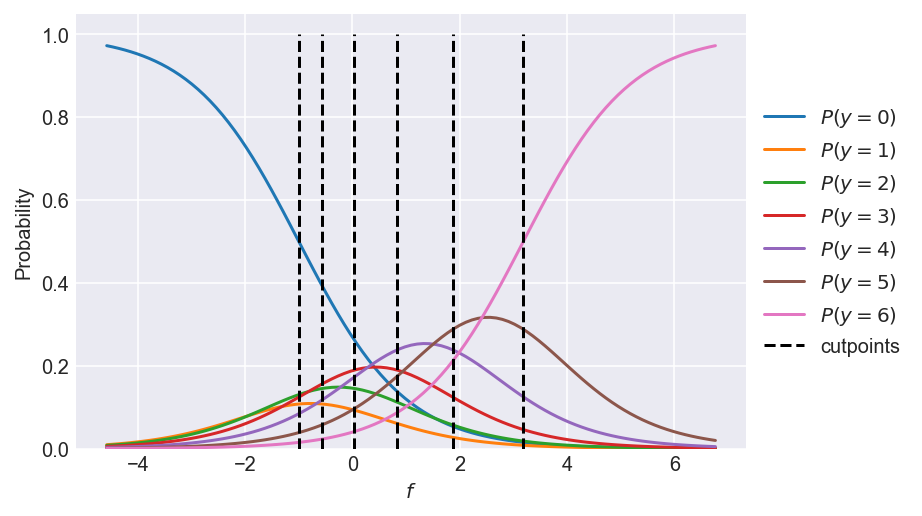

In [27]:
num_points = 101
cutpoints = model.ordinal.threshold.detach()
offset = cutpoints.std() + 2
print(cutpoints)

f = torch.linspace(cutpoints.min() - offset, 
                   cutpoints.max() + offset, 
                   num_points)

# plot_ordinal_classes(f, 
#                      cutpoints, 
#                      model.ordinal.func)

plot_ordinal_classes_from_layer(f, model.ordinal)

In [28]:
import torch.optim as optim

lr = 1e-2

criterion = OrdinalLoss()

opti = optim.Adam(model.parameters(), lr=lr)

In [29]:
model_output = model(X_train).detach()


In [30]:
from torch.utils.data import TensorDataset, DataLoader

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

# X_test, y_test


In [31]:
epochs = 10

for epoch in range(epochs):
    
    model.train()
    
    total_loss = 0
    
    for (data, label) in train_loader:
        
        opti.zero_grad()
        
        output = model(data)
        
        loss = criterion(output, label)
        
        loss.backward()
        
        opti.step()
        
        total_loss += loss.item() * len(label)
        
    print(f"[INFO {epoch}: LOSS: {total_loss/len(X_train)}]")
        
    model.eval()
    with torch.no_grad():
        output = model(X_train)
        print(f"[INFO {epoch}: ACC : {(output.argmax(-1) == y_train).float().mean():.3f}]")
        print(f"[INFO {epoch}: TOP : {(abs(output.argmax(-1) - y_train) < 2).float().mean():.3f}]")
        output = model(X_test)
        loss = criterion(output, y_test)
    print(f"[INFO {epoch}: LOSS: {loss.item()}]")
    print(f"[INFO {epoch}: ACC : {(output.argmax(-1) == y_test).float().mean():.3f}]")
    print(f"[INFO {epoch}: TOP : {(abs(output.argmax(-1) - y_test) < 2).float().mean():.3f}]")
    print()
        

[INFO 0: LOSS: 1.4530440774449298]
[INFO 0: ACC : 0.493]
[INFO 0: TOP : 0.951]
[INFO 0: LOSS: 1.2396634817123413]
[INFO 0: ACC : 0.512]
[INFO 0: TOP : 0.952]

[INFO 1: LOSS: 1.1721843142497532]
[INFO 1: ACC : 0.539]
[INFO 1: TOP : 0.955]
[INFO 1: LOSS: 1.1203032732009888]
[INFO 1: ACC : 0.551]
[INFO 1: TOP : 0.949]

[INFO 2: LOSS: 1.100414456565586]
[INFO 2: ACC : 0.531]
[INFO 2: TOP : 0.962]
[INFO 2: LOSS: 1.0714454650878906]
[INFO 2: ACC : 0.551]
[INFO 2: TOP : 0.958]

[INFO 3: LOSS: 1.079929678559831]
[INFO 3: ACC : 0.546]
[INFO 3: TOP : 0.958]
[INFO 3: LOSS: 1.0781340599060059]
[INFO 3: ACC : 0.556]
[INFO 3: TOP : 0.949]

[INFO 4: LOSS: 1.0638230398844957]
[INFO 4: ACC : 0.541]
[INFO 4: TOP : 0.962]
[INFO 4: LOSS: 1.049368143081665]
[INFO 4: ACC : 0.566]
[INFO 4: TOP : 0.959]

[INFO 5: LOSS: 1.0582758334248668]
[INFO 5: ACC : 0.535]
[INFO 5: TOP : 0.961]
[INFO 5: LOSS: 1.0528650283813477]
[INFO 5: ACC : 0.546]
[INFO 5: TOP : 0.959]

[INFO 6: LOSS: 1.0540944863012578]
[INFO 6: ACC :

In [32]:
print(model.ordinal.theta.detach())
print(model.ordinal.threshold.detach())
# print(model.ordinal.scale.detach())

tensor([-1.8643,  1.3681,  3.2056,  2.7362,  2.3320,  3.6311])
tensor([-1.8643, -0.2694,  2.9759,  5.7749,  8.1995, 11.8568])


tensor([-1.8643, -0.2694,  2.9759,  5.7749,  8.1995, 11.8568])


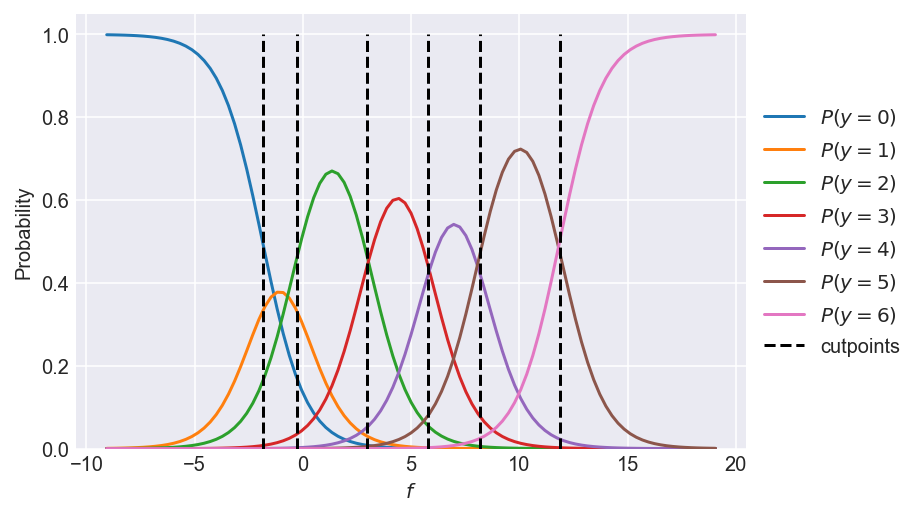

In [33]:
num_points = 101
cutpoints = model.ordinal.threshold.detach()
offset = cutpoints.std() + 2
print(cutpoints)

f = torch.linspace(cutpoints.min() - offset, 
                   cutpoints.max() + offset, 
                   num_points)

plot_ordinal_classes(f, 
                     cutpoints, 
                     model.ordinal.func)

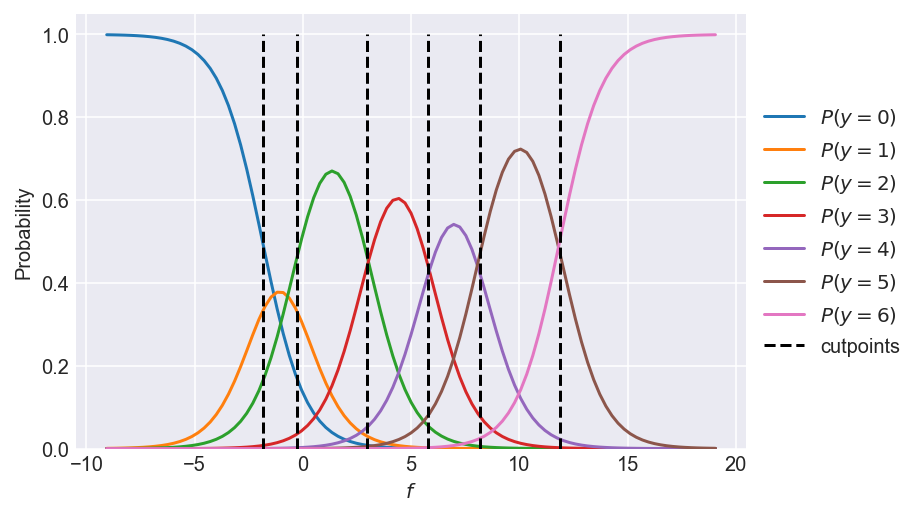

In [34]:
plot_ordinal_classes_from_layer(f, model.ordinal)

In [35]:
from sklearn.metrics import confusion_matrix

model.eval()
with torch.no_grad():
    cm_train = confusion_matrix(y_train, model(X_train).argmax(-1))
    cm_test = confusion_matrix(y_test, model(X_test).argmax(-1))

print(cm_train)
print()
print(cm_test)

[[   0    1   14    9    0    0    0]
 [   0    1  137   34    1    0    0]
 [   0    0 1129  574    7    0    0]
 [   0    0  531 1633  105    0    0]
 [   0    0   26  667  170    0    0]
 [   0    0    4  101   49    0    0]
 [   0    0    0    2    2    0    0]]

[[  0   0   5   1   0   0   0]
 [  0   0  29  14   0   0   0]
 [  0   0 277 150   1   0   0]
 [  0   0 127 416  24   0   0]
 [  0   0   5 165  46   0   0]
 [  0   0   1  31   7   0   0]
 [  0   0   0   0   1   0   0]]


In [36]:
# COMP WITH REG CLASSIFICATION

class Model(nn.Module):
    
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.predictor = nn.Sequential(
            nn.Linear(num_features, num_hidden),
            nn.ELU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ELU(),
            nn.Linear(num_hidden, num_classes, bias=True)
        )
        
    def forward(self, x):
        return self.predictor(x)
    
    
    
num_features = len(gaussian_columns + power_columns)
num_classes = len(np.unique(y))

print(num_features, num_classes)

model = Model(num_features, num_classes)

lr = 1e-2

criterion = nn.CrossEntropyLoss()

opti = optim.Adam(model.parameters(), lr=lr)



epochs = 10

for epoch in range(epochs):
    
    model.train()
    
    total_loss = 0
    
    for (data, label) in train_loader:
        
        opti.zero_grad()
        
        output = model(data)
        
        loss = criterion(output, label)
        
        loss.backward()
        
        opti.step()
        
        total_loss += loss.item() * len(label)
        
    print(f"[INFO {epoch}: LOSS: {total_loss/len(X_train)}]")
        
    model.eval()
    with torch.no_grad():
        output = model(X_train)
        print(f"[INFO {epoch}: ACC : {(output.argmax(-1) == y_train).float().mean():.3f}]")
        print(f"[INFO {epoch}: TOP : {(abs(output.argmax(-1) - y_train) < 2).float().mean():.3f}]")
        output = model(X_test)
        loss = criterion(output, y_test)
    print(f"[INFO {epoch}: LOSS: {loss.item()}]")
    print(f"[INFO {epoch}: ACC : {(output.argmax(-1) == y_test).float().mean():.3f}]")
    print(f"[INFO {epoch}: TOP : {(abs(output.argmax(-1) - y_test) < 2).float().mean():.3f}]")
    print()
        

11 7
[INFO 0: LOSS: 1.2165816635816675]
[INFO 0: ACC : 0.540]
[INFO 0: TOP : 0.947]
[INFO 0: LOSS: 1.0796048641204834]
[INFO 0: ACC : 0.540]
[INFO 0: TOP : 0.945]

[INFO 1: LOSS: 1.0888530825316183]
[INFO 1: ACC : 0.544]
[INFO 1: TOP : 0.950]
[INFO 1: LOSS: 1.0676987171173096]
[INFO 1: ACC : 0.547]
[INFO 1: TOP : 0.945]

[INFO 2: LOSS: 1.0737645460684437]
[INFO 2: ACC : 0.539]
[INFO 2: TOP : 0.956]
[INFO 2: LOSS: 1.0618643760681152]
[INFO 2: ACC : 0.543]
[INFO 2: TOP : 0.949]

[INFO 3: LOSS: 1.0648638758953888]
[INFO 3: ACC : 0.540]
[INFO 3: TOP : 0.957]
[INFO 3: LOSS: 1.0625529289245605]
[INFO 3: ACC : 0.567]
[INFO 3: TOP : 0.949]

[INFO 4: LOSS: 1.0579036905234747]
[INFO 4: ACC : 0.555]
[INFO 4: TOP : 0.961]
[INFO 4: LOSS: 1.0413862466812134]
[INFO 4: ACC : 0.556]
[INFO 4: TOP : 0.952]

[INFO 5: LOSS: 1.0503796528733096]
[INFO 5: ACC : 0.544]
[INFO 5: TOP : 0.958]
[INFO 5: LOSS: 1.04107666015625]
[INFO 5: ACC : 0.570]
[INFO 5: TOP : 0.953]

[INFO 6: LOSS: 1.045397422176979]
[INFO 6: 

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()
with torch.no_grad():
    cm_train = confusion_matrix(y_train, model(X_train).argmax(-1))
    cm_test = confusion_matrix(y_test, model(X_test).argmax(-1))

print(cm_train)
print()
print(cm_test)

[[   2    0   14    8    0    0    0]
 [   0    2  136   34    1    0    0]
 [   0    1 1137  558   14    0    0]
 [   0    1  588 1510  170    0    0]
 [   0    0   57  567  239    0    0]
 [   0    0    8   86   58    2    0]
 [   0    0    1    0    3    0    0]]

[[  0   0   5   1   0   0   0]
 [  0   2  24  17   0   0   0]
 [  0   1 285 139   3   0   0]
 [  0   0 135 392  40   0   0]
 [  0   0  16 133  67   0   0]
 [  0   0   2  26  11   0   0]
 [  0   0   0   0   1   0   0]]


In [39]:
class Model(nn.Module):
    
    def __init__(self, num_features):
        super().__init__()
        self.predictor = nn.Sequential(
            nn.Linear(num_features, num_hidden),
            nn.ELU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ELU(),
            nn.Linear(num_hidden, 1, bias=True)
        )
        
    def forward(self, x):
        return self.predictor(x)
    
    
    
num_features = len(gaussian_columns + power_columns)
num_classes = len(np.unique(y))

print(num_features, num_classes)

model = Model(num_features)

lr = 1e-2

criterion = nn.MSELoss()

opti = optim.Adam(model.parameters(), lr=lr)



epochs = 10

for epoch in range(epochs):
    
    model.train()
    
    total_loss = 0
    
    for (data, label) in train_loader:
        
        opti.zero_grad()
        
        output = model(data).view(-1)
        
        loss = criterion(output, label.float())
        
        loss.backward()
        
        opti.step()
        
        total_loss += loss.item() * len(label)
        
    print(f"[INFO {epoch}: LOSS: {total_loss/len(X_train)}]")
        
    model.eval()
    with torch.no_grad():
        output = model(X_train).view(-1)
        print(f"[INFO {epoch}: ACC : {(output.round() == y_train).float().mean():.3f}]")
        print(f"[INFO {epoch}: TOP : {(abs(output.round() - y_train) < 2).float().mean():.3f}]")
        output = model(X_test).view(-1)
        loss = criterion(output, y_test)
    print(f"[INFO {epoch}: LOSS: {loss.item()}]")
    print(f"[INFO {epoch}: ACC : {(output.round() == y_test).float().mean():.3f}]")
    print(f"[INFO {epoch}: TOP : {(abs(output.round() - y_test) < 2).float().mean():.3f}]")
    print()
        

11 7
[INFO 0: LOSS: 0.9249080961108873]
[INFO 0: ACC : 0.544]
[INFO 0: TOP : 0.953]
[INFO 0: LOSS: 0.5261837840080261]
[INFO 0: ACC : 0.549]
[INFO 0: TOP : 0.950]

[INFO 1: LOSS: 0.5425965133047297]
[INFO 1: ACC : 0.524]
[INFO 1: TOP : 0.958]
[INFO 1: LOSS: 0.524471640586853]
[INFO 1: ACC : 0.523]
[INFO 1: TOP : 0.955]

[INFO 2: LOSS: 0.5258662666991419]
[INFO 2: ACC : 0.523]
[INFO 2: TOP : 0.960]
[INFO 2: LOSS: 0.5136168599128723]
[INFO 2: ACC : 0.532]
[INFO 2: TOP : 0.954]

[INFO 3: LOSS: 0.5209999815165732]
[INFO 3: ACC : 0.530]
[INFO 3: TOP : 0.955]
[INFO 3: LOSS: 0.5344734787940979]
[INFO 3: ACC : 0.535]
[INFO 3: TOP : 0.950]

[INFO 4: LOSS: 0.5194077400466628]
[INFO 4: ACC : 0.541]
[INFO 4: TOP : 0.961]
[INFO 4: LOSS: 0.506256639957428]
[INFO 4: ACC : 0.549]
[INFO 4: TOP : 0.952]

[INFO 5: LOSS: 0.5140124106088326]
[INFO 5: ACC : 0.535]
[INFO 5: TOP : 0.962]
[INFO 5: LOSS: 0.502600371837616]
[INFO 5: ACC : 0.547]
[INFO 5: TOP : 0.953]

[INFO 6: LOSS: 0.5138369420755132]
[INFO 6: 

In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()
with torch.no_grad():
    cm_train = confusion_matrix(y_train, model(X_train).view(-1).round())
    cm_test = confusion_matrix(y_test, model(X_test).view(-1).round())

print(cm_train)
print()
print(cm_test)

[[   0    2   12   10    0    0    0]
 [   0    4  117   51    1    0    0]
 [   0    6  764  926   14    0    0]
 [   0    0  329 1718  222    0    0]
 [   0    0   15  590  258    0    0]
 [   0    0    0   81   73    0    0]
 [   0    0    0    1    3    0    0]]

[[  0   0   5   1   0   0   0]
 [  0   0  25  18   0   0   0]
 [  0   0 189 236   3   0   0]
 [  0   0  81 443  43   0   0]
 [  0   0   3 145  68   0   0]
 [  0   0   0  22  17   0   0]
 [  0   0   0   0   1   0   0]]
